In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind


Anapa_f = pd.read_csv('Anapa.csv')

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

#функции для сортировки данных

def sort_max(df, col, number):
    return df.sort_values(by=col, ascending=False).head(number)


def sort_min(df, col, number):
    return df.sort_values(by=col, ascending=False).tail(number)

#функция для определения затрат на топливо

def fuel(Anapa_f):
    if Anapa_f['aircraft_code'] == '733':
        val = Anapa_f['duration']*minute_cost_733
    else:
        val = Anapa_f['duration']*minute_cost_SU9
    return val    

#функция для построения столбцовой диаграммы

def barplot(col1, col2):
    ax = sns.barplot(x=col1, y=col2, data=Anapa_f)
    return ax


In [388]:
Anapa_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 126
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   flight_id               118 non-null    int64              
 1   flight_no               118 non-null    object             
 2   scheduled_departure     118 non-null    datetime64[ns, UTC]
 3   scheduled_arrival       118 non-null    object             
 4   departure_airport       118 non-null    object             
 5   arrival_airport         118 non-null    object             
 6   status                  118 non-null    object             
 7   aircraft_code           118 non-null    object             
 8   duration                118 non-null    float64            
 9   economy_capacity        118 non-null    int64              
 10  business_capacity       118 non-null    int64              
 11  economy_seats_sold      118 non-null    float

**Задачей настоящего датасета является определение малоприбыльных рейсов из Анапы в зимнее время для последующей их отмены.**

Для анализа предлагаем использовать следующие данные:

**flight_id** - уникальный идентификатор перелёта


**flight_no** - номер рейса


**scheduled_departure** - запланированное время вылета -- *представлены данные за январь, февраль, март 2017-го года*


**scheduled_arrival** - запланированное время прилета  -- *представлены данные за январь, февраль, март 2017-го года*


**departure_airport**  - аэропорт отправления -- *в финальном датасете представлены данные только с вылетом из AAQ(Анапы)*


**arrival_airport**  - аэропорт прибытия -- *в базе данные были собраны по трём направлениям SVO (Москва), EGO (Белгород) и NOZ (Новокузнецк), в результате первичного анализа данных рейсы NOZ (Новокузнецк) были удалены ввиду отсутствующих данных о стоимости и заполняемости бортов.*


**status** - статус рейса -- *в финальном датасете представлены данные только о выполненных рейсах со статусом arrived*  


**aircraft_code** - обозначение модели судна -- *в финальном датасете представлена информация о двух типах судна: 733 (Boeing 737-300) и SU9 (Sukhoi Superjet 100)*


**Дополнительно введённые параметры:**
 

**duration**  - длительность полёта в минутах      


**economy_capacity** - максимальная вместимость эконом-класса


**business_capacity** - максимальная вместимость бизнес-класса


**economy_seats_sold** - фактическая заполняемость эконом-класса


**business_seats_sold** - фактическая заполняемость бизнес-класса


**economy_amount**  - суммарная стоимость билетов эконом-класса


**business_amount**  - суммарная стоимость билетов бизнес-класса


**total_amount** - cуммарная стоимость всех билетов 


**profit** - условная прибыль, разница между стоимостью билетов на рейсе и стоимостью топлива


**fuel_perc** - процент, который составляет стоимость топлива от стоимости билетов


**total_capacity** - общая вместимость судна


**total_seats_sold** - общая фактическая заполняемость


**perc_capacity** - общий процент заполняемости рейса


**perc_capacity_business** - процент заполняемости бизнес-класса


**perc_capacity_economy** - процент заполняемости эконом-класса


**avg_price_economy** - средняя стоимость билета эконом-класса


**avg_price_business** - средняя стоимость билета бизнес-класса 


**departure_month** - месяц вылета (12/1/2)


**Для начала оценим качество собранных данных. При первой проверке видим, что в четырех столбцах есть пропуски, делаем проверку на наличие пропусков.**

In [359]:
Anapa_f[Anapa_f['economy_seats_sold'].isnull()]

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,duration,economy_capacity,business_capacity,economy_seats_sold,business_seats_sold,economy_amount,business_amount
59,136511,PG0194,2017-02-21T06:10:00Z,2017-02-21T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
60,136513,PG0194,2017-02-28T06:10:00Z,2017-02-28T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
61,136514,PG0194,2017-02-07T06:10:00Z,2017-02-07T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
62,136523,PG0194,2017-01-10T06:10:00Z,2017-01-10T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
63,136540,PG0194,2017-01-17T06:10:00Z,2017-01-17T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
64,136544,PG0194,2017-01-31T06:10:00Z,2017-01-31T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
65,136546,PG0194,2017-01-03T06:10:00Z,2017-01-03T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
66,136560,PG0194,2017-01-24T06:10:00Z,2017-01-24T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN
67,136567,PG0194,2017-02-14T06:10:00Z,2017-02-14T11:15:00Z,AAQ,NOZ,Arrived,733,305.0,118,12,NaN,NaN,NaN,NaN


Похоже, что по направлению NOZ (Новокузнецк) данные по фактическим полётам не собирались. Данная информация необходима для оценки прибыльности рейсов, поэтому эти строки мы удаляем из нашего датасета.

In [360]:
Anapa_f = Anapa_f.dropna()

Проверим данные на дубликаты.

In [361]:
Anapa_f['flight_id'].nunique()

118

Дубликатов нет. Таким образом, финальный датасет для анализа состоит из 24-х столбцов, в нём представлены данные о 118 рейсах.

## Попробуем определить затраты на топливо. ##

Boeing 737-300: удельный расход топлива — 22,5 г/пасс.-км или примерно 26 г/пасс.-км (на маршруте 925 км), часовой расход топлива — 2400 кг. 


Sukhoi Superjet 100: расчётный расход топлива на крейсерском режиме с 95 пассажирскими местами — 1700 кг/ч.

[Ссылка на источник](http://newsruss.ru/doc/index.php/%D0%A0%D0%B0%D1%81%D1%85%D0%BE%D0%B4_%D1%82%D0%BE%D0%BF%D0%BB%D0%B8%D0%B2%D0%B0_%D1%83_%D1%81%D0%B0%D0%BC%D0%BE%D0%BB%D1%91%D1%82%D0%BE%D0%B2#.D0.9F.D0.B0.D1.81.D1.81.D0.B0.D0.B6.D0.B8.D1.80.D1.81.D0.BA.D0.B8.D0.B5)

Таким образом, ориентировочный расход топлива за минуту полёта составляет:

**733 - 24 кг/мин**;



**SU9 - 17 кг/мин**.



По данным [Федерального Агентства Воздушного Транспорта](https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/?id=7329) стоимость топлива в январе 2017-го года в аэропорту Анапы составила 41435 руб/тонна, соответственно 41 руб/кг.

**Посчитаем стоимость расхода топлива в час:**

In [362]:
minute_cost_733 = 24*41
minute_cost_SU9 = 17*41
print('Стоимость одной минуты полёта модели 733 составляет', minute_cost_733, 'рубля.')
print('Стоимость одной минуты полёта модели SU9 составляет', minute_cost_SU9, 'рублей.')

Стоимость одной минуты полёта модели 733 составляет 984 рубля.
Стоимость одной минуты полёта модели SU9 составляет 697 рублей.


Теперь мы можем добавить новый признак к нашему датасету.

Объём затрат на топливо за рейс - **fuel_cost**

In [363]:
Anapa_f['fuel_cost'] = Anapa_f.apply(fuel, axis=1)

Добавим еще один признак - суммарную стоимость билетов - **total_amount**

In [364]:
Anapa_f['total_amount'] = Anapa_f['economy_amount']+Anapa_f['business_amount']

Посчитаем ориентировочную прибыльность - разницу между стоимостью топлива и стоимость билетов.

In [365]:
Anapa_f['profit'] = Anapa_f['total_amount'] - Anapa_f['fuel_cost']
Anapa_f['profit'] = Anapa_f['profit'].apply(lambda x: int(x))

In [366]:
sort_min(Anapa_f, 'profit', 5)

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,duration,economy_capacity,business_capacity,economy_seats_sold,business_seats_sold,economy_amount,business_amount,fuel_cost,total_amount,profit
120,136922,PG0480,2017-02-11T09:25:00Z,2017-02-11T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,66.0,10.0,418800.0,189000.0,34850.0,607800.0,572950
116,136887,PG0480,2017-01-20T09:25:00Z,2017-01-20T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,70.0,8.0,444000.0,151200.0,34850.0,595200.0,560350
109,136844,PG0480,2017-02-28T09:25:00Z,2017-02-28T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,73.0,6.0,461700.0,113400.0,34850.0,575100.0,540250
102,136807,PG0480,2017-02-23T09:25:00Z,2017-02-23T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,60.0,8.0,379800.0,151200.0,34850.0,531000.0,496150
77,136642,PG0480,2017-01-30T09:25:00Z,2017-01-30T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,54.0,10.0,342000.0,189000.0,34850.0,531000.0,496150


Видим, что самая низкая прибыльность у рейсов в Белгород. Это пока не говорит о нерентабельности рейса, так как расстояние и время полета до Белгорода меньше, чем до Москвы.

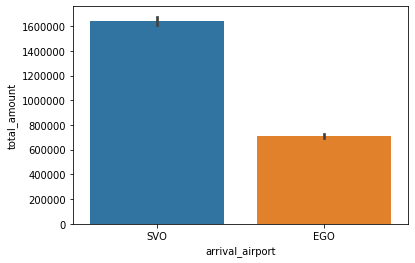

In [367]:
barplot('arrival_airport', 'total_amount')

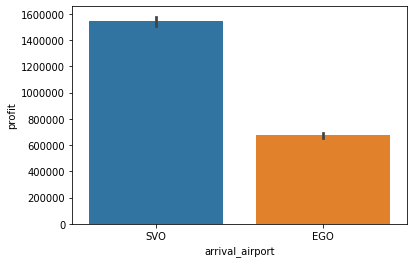

In [368]:
barplot('arrival_airport', 'profit')

Да, как и предполагалось, данный параметр не говорит об общей прибыльности.
Попробуем зайти с другой стороны - какой процент стоимость топлива составляет от совокупной стоимости билетов:

In [369]:
Anapa_f['fuel_perc'] = (Anapa_f['fuel_cost']/Anapa_f['total_amount'])

Чем процент затрат от общей прибыли на топливо выше, тем рейс может быть менее прибыльным.

In [370]:
sort_max(Anapa_f, 'fuel_perc', 5)

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,duration,economy_capacity,business_capacity,economy_seats_sold,business_seats_sold,economy_amount,business_amount,fuel_cost,total_amount,profit,fuel_perc
54,136464,PG0252,2017-01-09T10:05:00Z,2017-01-09T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,93.0,7.0,1141800.0,256200.0,98400.0,1398000.0,1299600,0.070386
21,136250,PG0252,2017-02-08T10:05:00Z,2017-02-08T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,91.0,8.0,1115000.0,292800.0,98400.0,1407800.0,1309400,0.069896
2,136122,PG0252,2017-01-08T10:05:00Z,2017-01-08T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,87.0,10.0,1065000.0,366000.0,98400.0,1431000.0,1332600,0.068763
12,136178,PG0252,2017-01-29T10:05:00Z,2017-01-29T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,90.0,9.0,1105200.0,329400.0,98400.0,1434600.0,1336200,0.068591
38,136360,PG0252,2017-02-05T10:05:00Z,2017-02-05T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,86.0,11.0,1052800.0,402600.0,98400.0,1455400.0,1357000,0.067610


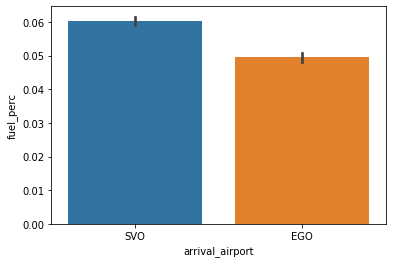

In [371]:
barplot('arrival_airport', 'fuel_perc')

In [372]:
Anapa_f['fuel_perc'].max()-Anapa_f['fuel_perc'].min()

0.024848568459506185

В целом, разница между самым "прибыльным" и "убыточным" рейсом составляет 0.02%, что кажется не очень существенным.

Пока приходим к выводу, что данных в датасете для оценки рентабельности недостаточно для определнных выводов.
Обратимся к открытым источникам. 
Находим [интервью](https://www.kommersant.ru/doc/3246832) генерального директора Аэрофлота Виталия Савельева, где говорится «Если загрузка кресел меньше, чем 75%, то рейс становится нерентабельным». Поработаем с этой информацией.

У нас есть максимальная загрузка судна по классам - economy-capacity и business_capacity и есть фактическая загрузка business_seats_sold и economy_seats_sold. Объединим пока данные по классам, чтобы определить процент заполняемости.

In [373]:
Anapa_f['total_capacity'] = Anapa_f['business_capacity'] + Anapa_f['economy_capacity']
Anapa_f['total_seats_sold'] = Anapa_f['economy_seats_sold'] + Anapa_f['business_seats_sold']

In [374]:
Anapa_f['perc_capacity'] = (Anapa_f['total_seats_sold']/Anapa_f['total_capacity'])

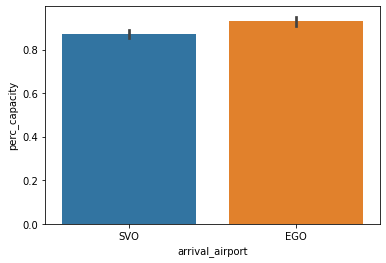

In [375]:
barplot('arrival_airport', 'perc_capacity')

Заполняемость рейсов в EGO(Белгород) в целом выше, но посмотрим всё же, какие рейсы согласно оценке генерального директора Аэрофлота мы можем считать нерентабельными:

In [376]:
Anapa_f[Anapa_f['perc_capacity'] < 0.75]

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,duration,economy_capacity,business_capacity,economy_seats_sold,business_seats_sold,economy_amount,business_amount,fuel_cost,total_amount,profit,fuel_perc,total_capacity,total_seats_sold,perc_capacity
2,136122,PG0252,2017-01-08T10:05:00Z,2017-01-08T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,87.0,10.0,1065000.0,366000.0,98400.0,1431000.0,1332600,0.068763,130,97.0,0.746154
38,136360,PG0252,2017-02-05T10:05:00Z,2017-02-05T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,86.0,11.0,1052800.0,402600.0,98400.0,1455400.0,1357000,0.067610,130,97.0,0.746154
77,136642,PG0480,2017-01-30T09:25:00Z,2017-01-30T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,54.0,10.0,342000.0,189000.0,34850.0,531000.0,496150,0.065631,97,64.0,0.659794
102,136807,PG0480,2017-02-23T09:25:00Z,2017-02-23T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,60.0,8.0,379800.0,151200.0,34850.0,531000.0,496150,0.065631,97,68.0,0.701031


Получаем 4 рейса с заполняемостью меньше 75%. Два из них SVO и два - EGO.

Интересно, что рейс PG0252 с id136122 и id136360 фигурирует как в рейтинге рейсов с наибольшими затратами на топливо по отношению к прибыли, так и в рейтинге с наименьшей заполняемостью.

Также посмотрим на показатели загрузки рейсов по классам для возможного увеличения прибыли.

In [377]:
Anapa_f['perc_capacity_business'] = (Anapa_f['business_seats_sold']/Anapa_f['business_capacity'])
Anapa_f['perc_capacity_economy'] = (Anapa_f['economy_seats_sold']/Anapa_f['economy_capacity'])

In [378]:
Anapa_f['perc_capacity_business'].mean()

0.8990112994350282

In [379]:
Anapa_f['perc_capacity_economy'].mean()

0.9001926424117476

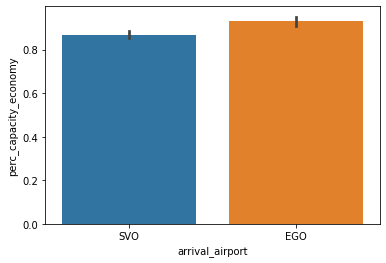

In [380]:
barplot('arrival_airport', 'perc_capacity_economy')

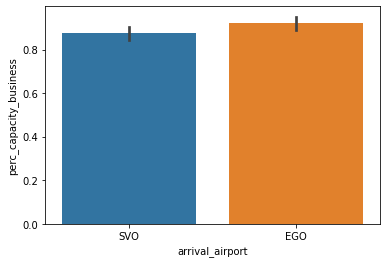

In [381]:
barplot('arrival_airport', 'perc_capacity_business')

Посмотрим на рейсы с максимальной заполняемостью.

In [382]:
Anapa_f[Anapa_f['perc_capacity'] == 1]

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,duration,economy_capacity,business_capacity,economy_seats_sold,business_seats_sold,economy_amount,business_amount,fuel_cost,total_amount,profit,fuel_perc,total_capacity,total_seats_sold,perc_capacity,perc_capacity_business,perc_capacity_economy
19,136226,PG0252,2017-01-30T10:05:00Z,2017-01-30T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,118.0,12.0,1446800.0,439200.0,98400.0,1886000.0,1787600,0.052174,130,130.0,1.0,1.0,1.0
32,136316,PG0252,2017-01-12T10:05:00Z,2017-01-12T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,118.0,12.0,1446800.0,439200.0,98400.0,1886000.0,1787600,0.052174,130,130.0,1.0,1.0,1.0
70,136600,PG0480,2017-02-08T09:25:00Z,2017-02-08T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0
71,136605,PG0480,2017-02-15T09:25:00Z,2017-02-15T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0
93,136755,PG0480,2017-01-21T09:25:00Z,2017-01-21T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0
94,136757,PG0480,2017-01-27T09:25:00Z,2017-01-27T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0
95,136758,PG0480,2017-01-12T09:25:00Z,2017-01-12T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0
100,136781,PG0480,2017-01-14T09:25:00Z,2017-01-14T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0
103,136815,PG0480,2017-02-19T09:25:00Z,2017-02-19T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0
106,136827,PG0480,2017-02-18T09:25:00Z,2017-02-18T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,85.0,12.0,538500.0,226800.0,34850.0,765300.0,730450,0.045538,97,97.0,1.0,1.0,1.0


In [383]:
Anapa_f[Anapa_f['perc_capacity'] < 0.75]

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,duration,economy_capacity,business_capacity,economy_seats_sold,business_seats_sold,economy_amount,business_amount,fuel_cost,total_amount,profit,fuel_perc,total_capacity,total_seats_sold,perc_capacity,perc_capacity_business,perc_capacity_economy
2,136122,PG0252,2017-01-08T10:05:00Z,2017-01-08T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,87.0,10.0,1065000.0,366000.0,98400.0,1431000.0,1332600,0.068763,130,97.0,0.746154,0.833333,0.737288
38,136360,PG0252,2017-02-05T10:05:00Z,2017-02-05T11:45:00Z,AAQ,SVO,Arrived,733,100.0,118,12,86.0,11.0,1052800.0,402600.0,98400.0,1455400.0,1357000,0.067610,130,97.0,0.746154,0.916667,0.728814
77,136642,PG0480,2017-01-30T09:25:00Z,2017-01-30T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,54.0,10.0,342000.0,189000.0,34850.0,531000.0,496150,0.065631,97,64.0,0.659794,0.833333,0.635294
102,136807,PG0480,2017-02-23T09:25:00Z,2017-02-23T10:15:00Z,AAQ,EGO,Arrived,SU9,50.0,85,12,60.0,8.0,379800.0,151200.0,34850.0,531000.0,496150,0.065631,97,68.0,0.701031,0.666667,0.705882


Интересно, что рейс PG0252 в SVO дважды был с максимальной заполняемостью и при этом возглавил рейтинг нерентабельных рейсов. 

Может быть, дело в стоимости билетов? Сравним среднюю стоимость.

In [384]:
Anapa_f['avg_price_economy'] = Anapa_f['total_amount']//Anapa_f['economy_seats_sold']
Anapa_f['avg_price_business'] = Anapa_f['total_amount']//Anapa_f['business_seats_sold']

**При заполненности на 100%:**

Средняя стоимость билета в эконом-классе составила 15983 руб.

Средняя стоимость билет в бизнес-классе составила 157166.0

**При заполненности  72%:**
    
    
Средняя стоимость билета в эконом-классе составила 16923.0 руб.

Средняя стоимость билет в бизнес-классе составила 132309.0 руб.

## Посмотрим на зависимость заполняемости от конкретного месяца. ##

Для этого поработаем с форматами и добавим столбец с номером месяца.

In [385]:
Anapa_f['scheduled_departure'] = pd.to_datetime(Anapa_f['scheduled_departure'])
Anapa_f['departure_month'] = Anapa_f['scheduled_departure'].dt.month

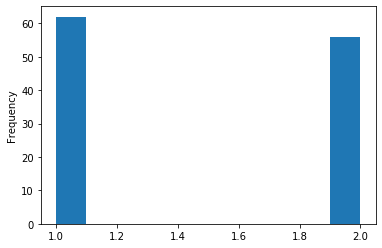

In [386]:
Anapa_f['departure_month'].plot(kind = 'hist')

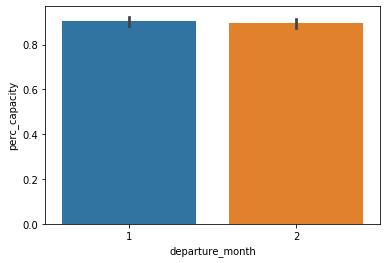

In [387]:
barplot('departure_month', 'perc_capacity')

Заполняемость рейсов в январе и феврале примерно равна. 

### ВЫВОДЫ:###
- В выборке использовались данные рейсов из Анапы в Белгород(EGO) и Москва(SVO).
- Анализируемый период - январь и февраль 2017-го года.
- Наиболее подходящим рейсом для оптимизации является рейс PG0252 (id 136360 и  id 136122), его заполняемость в некоторые дни составила меньше 75% за выбранный период и при этом (или поэтому) процент затрат на топливо по отношению к общей стоимости билетов оказался самым высоким. При низких уровнях продаж также можно рассмотреть возможность замены судна на судно меньшей вместимости в целях экономии топлива. Также дважды этот рейс был заполнен на 100%, при этом стоимость билетов в эконом-классе была выше в дни "недозагрузки".
- Рейс PG0480 в Бегород (EGO) стоит рассмотреть на предмет увеличения стоимости, увеличения частоты полётов или замены типа судна на более вместительное, так как его заполняемость 16 раз составила 100%.
- Рекомендуем для последующего анализа дополнить данные статьями расходов на лизинг/стоимость судна, амортизацию, зарплаты обслуживающего персонала, административные расходы.


[Ссылка на презентацию](https://drive.google.com/file/d/1I5T1ibYuADJwTi016lFD3wVc92g-wHkQ/view?usp=sharing)